# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

<img src= /home/luisub/Desktop/FISH_Processing/docs/images/code_architecture.png alt="drawing" width="1000"/>

### Libraries

In [73]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import tifffile
import pathlib
import warnings
import shutil
import zipfile
import os
import seaborn as sns
import pandas as pd
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

----

# Parameters defined by the user 

----

### Paths to images

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')



#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220927/A549_NFKBIA_woSTM' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220927/A549_NFKBIA_10minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220927/A549_NFKBIA_20minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_30minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_40minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_50minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_60minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_75minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_90minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_120minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220928/A549_NFKBIA_150minDEX' )
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220930/A549_NFKBIA_180minDEX' )

#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20211014/MS2-CY5-0minTPL' )
#data_folder_path = pathlib.Path('Test/MS2-CY5_Cyto543_560_5hTPL_5uM' )

### Remote directories
#data_folder_path = pathlib.Path('Test','test_dir')
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_wo_IL-1B' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_2h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_6h' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220114/GAPDH-Cy3_NFKBIA-Cy5_woDex' )
#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220216/GAPDH-Cy3_NFKBIA-Cy5_10min_100nM_DEX_Rep2')
#data_folder_path =pathlib.Path('smFISH_images/Eric_smFISH_images/20211109/MS2_Cy3_TPL_0min')

#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220721/RPE_GoldMedium_32P_COX-2_2h_30ng_mL_IL-B')
#data_folder_path = pathlib.Path('/home/luisub/Desktop/FISH_Processing/notebooks/temp_RPE_GoldMedium_32P_COX-2_2h_30ng_mL_IL-B')
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM')
#data_folder_path = pathlib.Path('/home/luisub/Desktop/FISH_Processing/notebooks/temp_MS2-CY5_Cyto543_560_5hTPL_5uM/merged')
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220801/RPE_GoldMedium_32P_COX-2_30ng_mL_IL-1B-4h_Cyto543_560')
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220728/RPE_GoldMedium_32P_COX-2_30ng_mL_IL-1B-1h_Cyto543_560')
#data_folder_path = pathlib.Path('/home/luisub/Desktop/FISH_Processing/notebooks/test_marker2')

#path_to_masks_dir =pathlib.Path('/home/luisub/Desktop/FISH_Processing/notebooks/masks_test_marker2')
#path_to_masks_dir = pathlib.Path('/home/luisub/Desktop/FISH_Processing/notebooks/masks_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_90__cyto_160')
#path_to_masks_dir = pathlib.Path('Test/test_dir/masks_test_dir___nuc_120__cyto_220.zip')
#path_to_masks_dir = pathlib.Path('/home/luisub/Desktop/FISH_Processing/notebooks/masks_RPE_GoldMedium_32P_COX-2_2h_30ng_mL_IL-B')
#download_data_from_NAS = True
#send_data_to_NAS=True

#### Local directories
data_folder_path = current_dir.parents[0].joinpath('dataBases').joinpath('test_data_1R')
path_to_masks_dir = None #current_dir.parents[0].joinpath('dataBases').joinpath('masks_test_data')
#data_folder_path = current_dir.parents[0].joinpath('dataBases').joinpath('GabeIFimages_512')  # GabeIFimages_1024 # GabeIFimages_512
#/home/luisub/Desktop/FISH_Processing/dataBases/GabeIFimages/Cell02.tif
#path_to_masks_dir = None # current_dir.parents[0].joinpath('dataBases').joinpath('masks_test_data')


In [4]:
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_30ngmL_IL1B_2h_GoldMedia')
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_COX2_woSTM_GoldMedia')

#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_NFKBIA_100nMDEX_2h')
#data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220914/A549_NFKBIA_woSTM')

#path_to_masks_dir = None   # full path to a zip file

In [5]:
#data_folder_path = current_dir.parents[0].joinpath('notebooks').joinpath('test_linda')
#path_to_masks_dir = current_dir.parents[0].joinpath('notebooks').joinpath('masks_test_linda')

In [6]:
download_data_from_NAS = False
send_data_to_NAS = False

### Parameters for segmentation and spot detection

In [7]:
# Parameters fo cell segmentation 
channels_with_cytosol = [2]          # list or int indicating the channels where the cytosol is detectable. Use None to not segment the cytosol.
channels_with_nucleus = [0]                  # list or int indicating the channels where the nucleus is detectable. Use None to not segment the cytosol.
channels_with_FISH = [1]                     # list or int with the channels with FISH spots that are used for the quantification
diameter_nucleus = 81                        # approximate nucleus size in pixels
diameter_cytosol = 200                         # approximate cytosol size in pixels

# Parameters for FISH detection
voxel_size_z = 500                          # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 160                         # Microscope conversion px to nanometers in the xy axis.
psf_z = 350                                 # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx = 160                                # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.

# Cluster Detection
minimum_spots_cluster = 3                   # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots = True                          # Flag to display plots
optimization_segmentation_method = 'z_slice_segmentation' #  # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , 'z_slice_segmentation_marker' , 'center_slice', None
save_all_images=False                       # If true, it shows a all planes for the FISH plot detection. 
threshold_for_spot_detection = None         # Intensity threshold to detect  spots. If None, it will automatically detect the spots. Pass a list if you have more than one FISH channel.
save_filtered_images = False

In [8]:
# If more than one channel contain FISH spots. This section will create a list of thresholds for spot detection and for each channel. 
if not(isinstance(channels_with_FISH, list)):
    channels_with_FISH=[channels_with_FISH]
list_threshold_for_spot_detection=[]
if not isinstance(threshold_for_spot_detection, list):
    for i in range (len(channels_with_FISH)):
        list_threshold_for_spot_detection.append(threshold_for_spot_detection)
else:
    list_threshold_for_spot_detection = threshold_for_spot_detection
# Lists for thresholds
if (isinstance(list_threshold_for_spot_detection, list)) and (len(list_threshold_for_spot_detection) < len(channels_with_FISH)):
    for i in range (len(channels_with_FISH)):
        list_threshold_for_spot_detection.append(list_threshold_for_spot_detection[0])

In [9]:
# If only a section  of z-slices is needed to process pass it as a list of integers with consecutive values. If all z-slices are required use None.
list_selected_z_slices = None #[6,7,8,9] # subsection of slices to process.


In [10]:
# names for final folders
    
if (threshold_for_spot_detection is None):
  name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) +'__cyto_' + str(diameter_cytosol) +'__psfz_' + str(psf_z) +'__psfyx_' + str(psf_yx)+'__ts_auto'
else:
  #name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) +'__cyto_' + str(diameter_cytosol) +'__psfz_' + str(psf_z) +'__psfyx_' + str(psf_yx)+'__ts_'+str(threshold_for_spot_detection)
  name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) +'__cyto_' + str(diameter_cytosol) +'__psfz_' + str(psf_z) +'__psfyx_' + str(psf_yx)+'__ts'
  for i in range (len(channels_with_FISH)):
    name_final_folder+='_'+ str(list_threshold_for_spot_detection[i])


## Connecting to NAS and Downloading data

In [11]:
# Download data from NAS
if download_data_from_NAS == True:
    share_name = 'share'
    local_data_dir, masks_dir = fa.Utilities.download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200)
else:
    local_data_dir = data_folder_path 
    masks_dir = path_to_masks_dir 

In [41]:
# Detecting if images need to be merged
is_needed_to_merge_images = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).checking_images()
if is_needed_to_merge_images == True:
    _, list_images, number_images, output_to_path = fa.MergeChannels(local_data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    local_data_dir = local_data_dir.joinpath('merged')
else:
    list_images, path_files, list_files_names, number_images = fa.ReadImages(directory= local_data_dir).read()
# Printing image properties
number_color_channels = list_images[0].shape[-1] 
print('Image shape: ', list_images[0].shape , '\n')
print('Number of images: ',number_images , '\n')
print('Local directory with images: ', local_data_dir, '\n')
del list_images

Image shape:  (23, 928, 624, 3) 

Number of images:  1 

Local directory with images:  /home/luisub/Desktop/FISH_Processing/dataBases/test_data_1R 



## Running the pipeline

----

 ############### 
       IMAGE : 0
 ############### 
 
ORIGINAL IMAGE
ROI002_XY1620755646_Z00_T0_merged.tif
(23, 928, 624, 3)


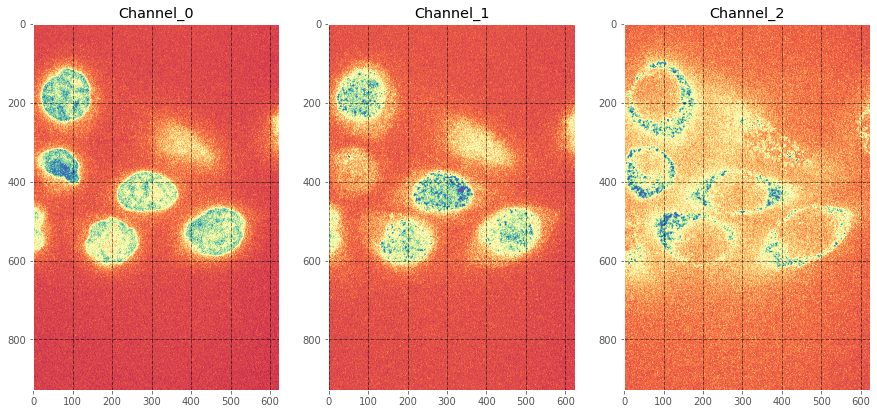

CELL SEGMENTATION
No cells detected on the image
SPOT DETECTION
Spot Detection for Channel : 1
sigma_value (z,y,x) = (0.7, 1.0, 1.0)
Int threshold used for the detection of spots:  345.0


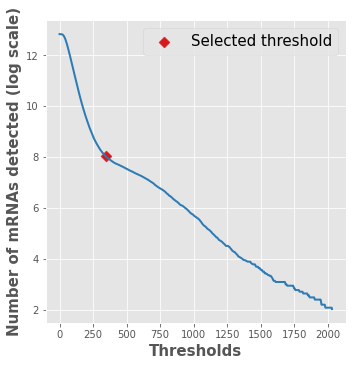

Z-Slice:  11


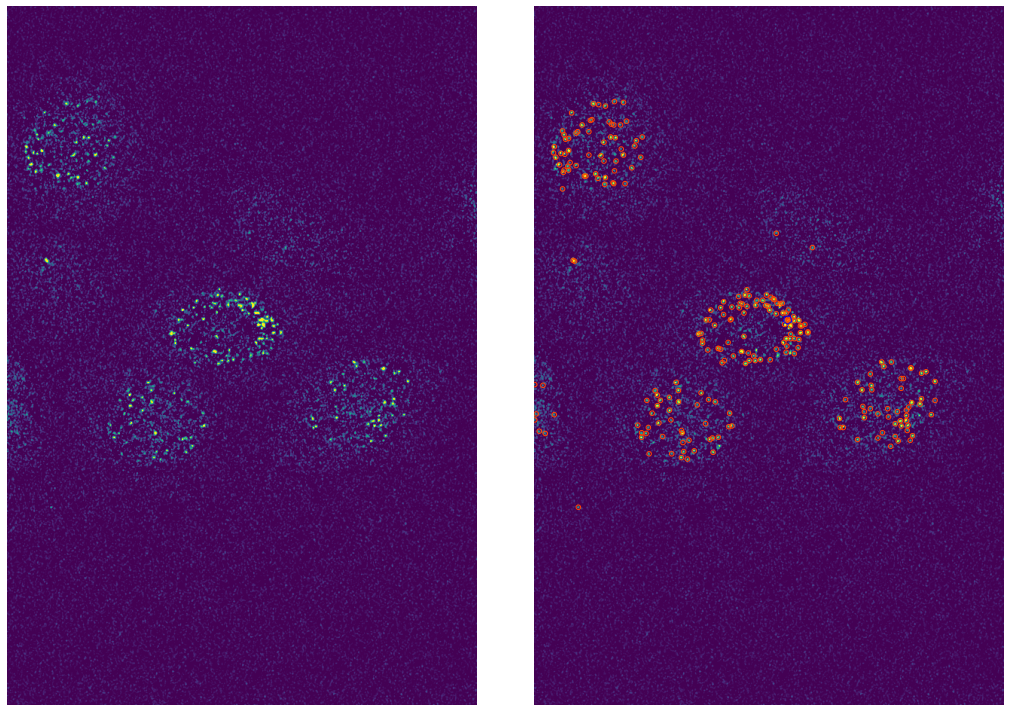

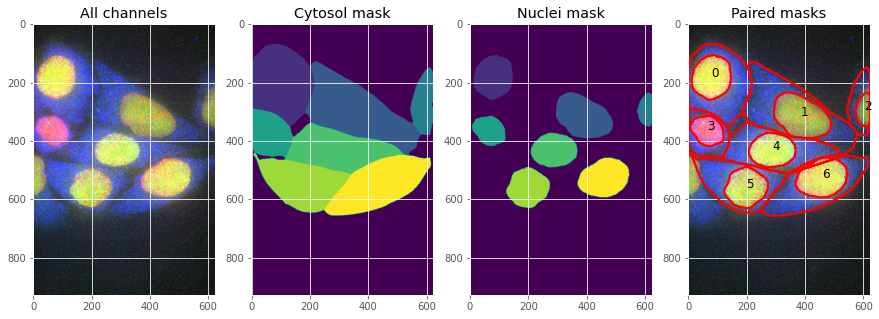

CREATING THE METADATA FILE
CREATING THE PDF REPORT


In [13]:
dataframe_FISH,_,_,_ = fa.PipelineFISH(local_data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, diameter_cytosol, minimum_spots_cluster, 
                                        masks_dir=masks_dir,  voxel_size_z=voxel_size_z, voxel_size_yx=voxel_size_yx ,psf_z=psf_z,psf_yx=psf_yx, show_plots=show_plots,
                                        file_name_str =data_folder_path.name, optimization_segmentation_method = optimization_segmentation_method,save_all_images=save_all_images,
                                        threshold_for_spot_detection=list_threshold_for_spot_detection,list_selected_z_slices=list_selected_z_slices ,save_filtered_images=save_filtered_images ).run()


## Extracting data from the dataframe

----

In [14]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.head()

,image_id,cell_id,spot_id,nuc_loc_y,nuc_loc_x,cyto_loc_y,cyto_loc_x,nuc_area_px,cyto_area_px,cell_area_px,...,is_cell_fragmented,nuc_int_ch_0,nuc_int_ch_1,nuc_int_ch_2,cyto_int_ch_0,cyto_int_ch_1,cyto_int_ch_2,spot_int_ch_0,spot_int_ch_1,spot_int_ch_2
0,0,0,0,181,80,200,103,15840,29468,45308,...,1,1373.6598,1236.946,1104.5061,998.6567,940.2089,1302.6717,-38.814815,60.333333,-61.259259
1,0,0,1,181,80,200,103,15840,29468,45308,...,1,1373.6598,1236.946,1104.5061,998.6567,940.2089,1302.6717,-80.037037,711.296296,-91.888889
2,0,0,2,181,80,200,103,15840,29468,45308,...,1,1373.6598,1236.946,1104.5061,998.6567,940.2089,1302.6717,-16.647266,1091.354497,-1.029982
3,0,0,3,181,80,200,103,15840,29468,45308,...,1,1373.6598,1236.946,1104.5061,998.6567,940.2089,1302.6717,186.962963,1175.481481,-4.0
4,0,0,4,181,80,200,103,15840,29468,45308,...,1,1373.6598,1236.946,1104.5061,998.6567,940.2089,1302.6717,53.888889,195.666667,46.185185


In [15]:
dataframe_FISH.tail()

,image_id,cell_id,spot_id,nuc_loc_y,nuc_loc_x,cyto_loc_y,cyto_loc_x,nuc_area_px,cyto_area_px,cell_area_px,...,is_cell_fragmented,nuc_int_ch_0,nuc_int_ch_1,nuc_int_ch_2,cyto_int_ch_0,cyto_int_ch_1,cyto_int_ch_2,spot_int_ch_0,spot_int_ch_1,spot_int_ch_2
3043,0,6,637,527,459,550,438,18021,26270,44291,...,0,1317.6287,1202.0312,1114.912,994.505,945.0933,1192.4587,-271.066667,684.066667,-104.866667
3044,0,6,638,527,459,550,438,18021,26270,44291,...,0,1317.6287,1202.0312,1114.912,994.505,945.0933,1192.4587,-460.866667,1311.6,93.333333
3045,0,6,639,527,459,550,438,18021,26270,44291,...,0,1317.6287,1202.0312,1114.912,994.505,945.0933,1192.4587,-19.866667,1167.533333,-261.0
3046,0,6,640,527,459,550,438,18021,26270,44291,...,0,1317.6287,1202.0312,1114.912,994.505,945.0933,1192.4587,-164.533333,938.8,312.2
3047,0,6,641,527,459,550,438,18021,26270,44291,...,0,1317.6287,1202.0312,1114.912,994.505,945.0933,1192.4587,-28.066667,901.333333,190.0


In [16]:
# generating a table with center of mass and cell and image id.

#dataframe_FISH.loc[ :, ['image_id','cell_id','nucleus_y','nucleus_x']]
#df_test = dataframe_FISH.drop_duplicates(subset= ['image_id','cell_id','nucleus_y','nucleus_x'] )
#df_test1 = dataframe_FISH.loc[ :, ['image_id','cell_id','nucleus_y','nucleus_x']].drop_duplicates()
#df_test1

#df_subset = dataframe_FISH.loc[dataframe_FISH['image_id'] == 1]
#df_labels = df_subset.loc[ :, ['cell_id','nucleus_y','nucleus_x']].drop_duplicates()
#df_labels             

In [17]:
# Number of cells
spot_type_selected = 0
number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i)  & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1)  ].spot_id) for i in range(0, number_cells)]
# Number of spots in cytosol
number_of_spots_per_cell_cytosol = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) & (dataframe_FISH['is_nuc']==False) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of spots in nucleus
number_of_spots_per_cell_nucleus = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected)  & (dataframe_FISH['is_cell_fragmented']!=-1)   ].spot_id) for i in range(0, number_cells)]
# Number of TS per cell.
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['cluster_size'] >=minimum_spots_cluster) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1)  ].cluster_size.values
# Size of each cell
cell_size = [dataframe_FISH.loc[dataframe_FISH['cell_id']==i].cell_area_px.values[0] for i in range(0, number_cells)]


7


## Plotting

----

In [18]:
# Plotting intensity distributions
plt.style.use('ggplot')  # ggplot  #default
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
  n, bins, _ = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
  plt.title(title, size=16)
  return (f)

<Figure size 432x288 with 0 Axes>

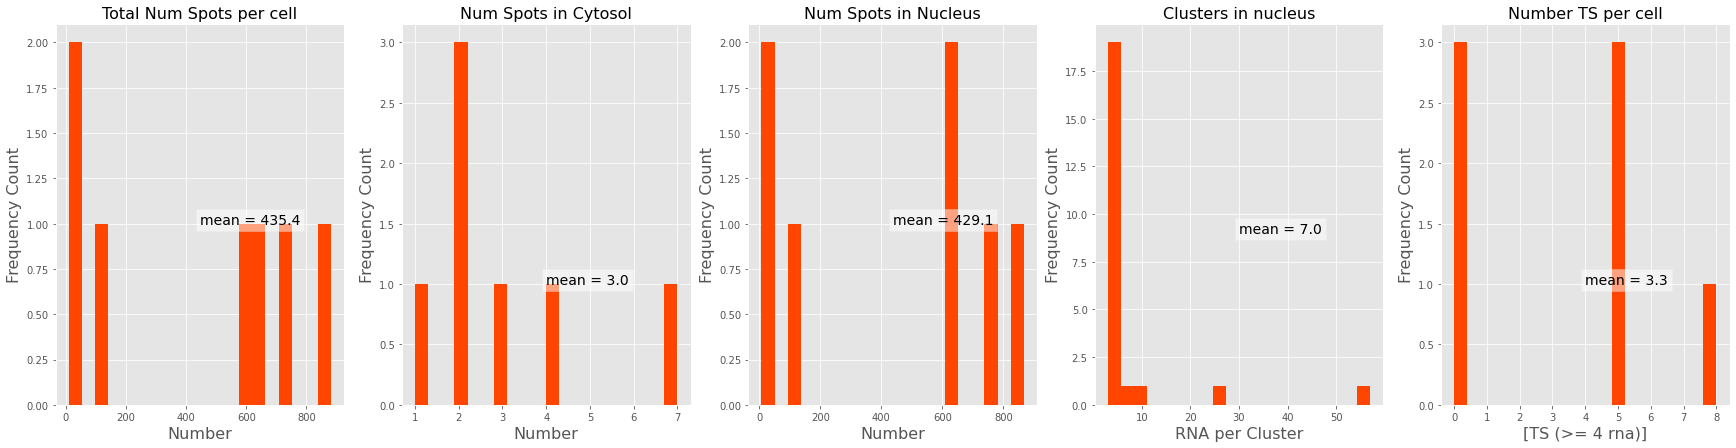

In [19]:
#Plotting
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)
#ylab='Probability'
ylab='Frequency Count'  
# adding subplots
f.add_subplot(1,5,1) 
plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,2) 
plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,3) 
plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,4) 
plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,5) 
plot_probability_distribution(number_of_TS_per_cell ,  numBins=20, title='Number TS per cell', xlab='[TS (>= 4 rna)]', ylab=ylab, fig=f, color='orangered')
plt.savefig('plots_'+data_folder_path.name+'.png')
plt.show()

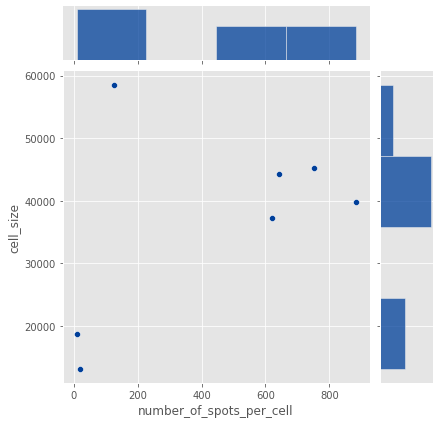

In [29]:
# Plotting Cell size vs number of spots per cell
df_join_distribution = pd.DataFrame({"number_of_spots_per_cell":number_of_spots_per_cell,"cell_size":cell_size})
sns.jointplot(data=df_join_distribution, x="number_of_spots_per_cell", y="cell_size",kind='scatter',color="#003f9a") #,kind='hex','resid','kde'

## Saving results

In [22]:
# create results folder
if not os.path.exists(str('analysis_'+ name_final_folder)):
    os.makedirs(str('analysis_'+ name_final_folder))    

#figure_path 
pathlib.Path().absolute().joinpath('plots_'+ data_folder_path.name +'.png').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'plots_'+ data_folder_path.name +'.png'))
#metadata_path
pathlib.Path().absolute().joinpath('metadata_'+ data_folder_path.name +'.txt').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'metadata_'+ data_folder_path.name +'.txt'))
#dataframe_path 
pathlib.Path().absolute().joinpath('dataframe_' + data_folder_path.name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'dataframe_'+ data_folder_path.name +'.csv'))
#pdf_path 
pathlib.Path().absolute().joinpath('pdf_report_' + data_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder    ),'pdf_report_'+ data_folder_path.name +'.pdf'))


PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks/analysis_test_data_1R___nuc_81__cyto_200__psfz_350__psfyx_160__ts_auto/pdf_report_test_data_1R.pdf')

## Sending results to NAS

----

In [23]:
# Writing analyses data to NAS
analysis_folder_name = 'analysis_'+ name_final_folder
if send_data_to_NAS == True:
    shutil.make_archive(analysis_folder_name,'zip',pathlib.Path().absolute().joinpath(analysis_folder_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip'))

In [24]:
# Writing masks to NAS
if path_to_masks_dir == None: 
    mask_folder_created_by_pipeline = 'masks_'+ data_folder_path.name # default name by pipeline
    name_final_masks = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) 
    mask_dir_complete_name = 'masks_'+ name_final_masks # final name for masks dir
    shutil.move(mask_folder_created_by_pipeline, mask_dir_complete_name ) # remaing the masks dir
else: 
    mask_dir_complete_name = masks_dir.name
    
if (send_data_to_NAS == True) and (path_to_masks_dir == None) :
    shutil.make_archive( mask_dir_complete_name , 'zip', pathlib.Path().absolute().joinpath(mask_dir_complete_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip'))

## Removing temporal local files

----

In [25]:
# Moving all results to "analyses" folder
if not os.path.exists(str('analyses')):
    os.makedirs(str('analyses'))

# Subfolder name
final_dir_name =pathlib.Path().absolute().joinpath('analyses', analysis_folder_name)

# Removing directory if exist
if os.path.exists(str(final_dir_name)):
    shutil.rmtree(str(final_dir_name))

# Moving results to a subdirectory in 'analyses' folder
pathlib.Path().absolute().joinpath(analysis_folder_name).rename(final_dir_name )

# Moving masks to a subdirectory in 'analyses' folder
if (download_data_from_NAS == True) or (path_to_masks_dir == None):
    final_mask_dir_name = pathlib.Path().absolute().joinpath('analyses', mask_dir_complete_name)
    if os.path.exists(str(final_mask_dir_name)):
        shutil.rmtree(str(final_mask_dir_name))
    pathlib.Path().absolute().joinpath(mask_dir_complete_name).rename(final_mask_dir_name )


# mask_folder_created_by_pipeline = 'masks_'+ data_folder_path.name # default name by pipeline
# filtered_images_dir_name = pathlib.Path().absolute().joinpath('analyses', mask_dir_complete_name)
# pathlib.Path().absolute().joinpath(mask_dir_complete_name).rename(final_mask_dir_name )

if save_filtered_images == True:
    filtered_folder_name = 'filtered_images_' + data_folder_path.name 
    pathlib.Path().absolute().joinpath(filtered_folder_name).rename(pathlib.Path().absolute().joinpath('analyses',str('analysis_'+ name_final_folder    ),filtered_folder_name))



# Delete local temporal files
temp_results_folder_name = pathlib.Path().absolute().joinpath('temp_results_' + data_folder_path.name)
shutil.rmtree(temp_results_folder_name)

if (download_data_from_NAS == True):
    # Delete temporal images downloaded from NAS
    shutil.rmtree(local_data_dir)

In [26]:
dataframe_FISH.columns

Index(['image_id', 'cell_id', 'spot_id', 'nuc_loc_y', 'nuc_loc_x',
       'cyto_loc_y', 'cyto_loc_x', 'nuc_area_px', 'cyto_area_px',
       'cell_area_px', 'z', 'y', 'x', 'is_nuc', 'is_cluster', 'cluster_size',
       'spot_type', 'is_cell_fragmented', 'nuc_int_ch_0', 'nuc_int_ch_1',
       'nuc_int_ch_2', 'cyto_int_ch_0', 'cyto_int_ch_1', 'cyto_int_ch_2',
       'spot_int_ch_0', 'spot_int_ch_1', 'spot_int_ch_2'],
      dtype='object')

In [74]:
spot_intensity_ts = dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True)  &( dataframe_FISH['cluster_size']>=2) ].spot_int_ch_1.values
spot_intensity = dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==False) ].spot_int_ch_1.values

print(spot_intensity_ts.shape)
print(spot_intensity.shape)

(23,)
(3025,)


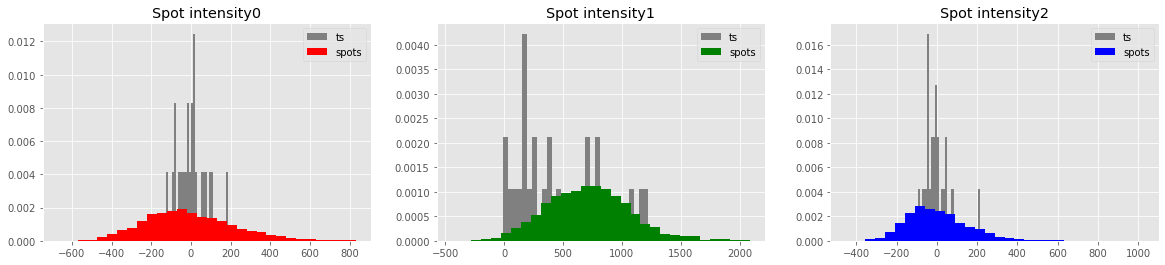

In [82]:
import matplotlib.pyplot as plt 

_, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 4))
colors = ['r','g','b','m']
for i in range (0,number_color_channels ):
    column_name = 'spot_int_ch_'+str(i)
    df_spot_intensity_ts = dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) ]
    spot_intensity_ts = df_spot_intensity_ts[column_name].values
    df_spot_intensity = dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==False) ]
    spot_intensity = df_spot_intensity[column_name].values
    ax[i].hist(x=spot_intensity_ts, bins=30, density = True, histtype ='bar',color = [0.5]*3,label = 'ts')
    ax[i].hist(x=spot_intensity, bins=30, density = True, histtype ='bar',color = colors[i],label = 'spots')
    ax[i].legend(prop ={'size': 10})
    ax[i].set_title('Spot intensity'+str(i))
plt.show()

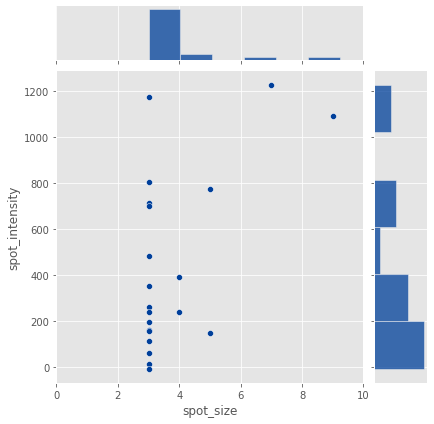

In [66]:
# Plotting Cell size vs number of spots per cell
spot_intensity_ts = dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True)  ].spot_int_ch_1.values
spot_size_ts = dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) ].cluster_size.values
#spot_intensity = dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==False) ].spot_int_ch_1.values

df_join_distribution_spots = pd.DataFrame({"spot_size":spot_size_ts,"spot_intensity":spot_intensity_ts})
plot = sns.jointplot(data=df_join_distribution_spots, x="spot_size", y="spot_intensity",kind='scatter',color="#003f9a") #,kind='hex','resid','kde'
plot.ax_marg_x.set_xlim(0, 10)
#plot.ax_marg_y.set_ylim(0, 1200)
plt.show()